In [1]:
#Añadir la raiz del proyecto temporal
import sys
sys.path.insert(0, "/home/ubuntu/projects/historical-analysis-management-tickets")

In [2]:
#dependencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob
import os
from src.configuraciones import configuracion_visual
from src.configuraciones import configuracion_format_df

In [3]:
#cargar dfs
folder_p = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed_SC"
df_all = pd.read_csv(f"{folder_p}/df_all.csv")

In [4]:
#configuracion
#visual
configuracion_visual()

#arreglo de datos
df_all = configuracion_format_df(df_all)

#vista de df
print("Dataframe cargado con éxito. Dimensiones:", df_all.shape)
print(f"Tickets disponibles: {df_all.shape[0]}")
print("Columnas disponibles:", df_all.columns.tolist())

Configurado visualmente
Configuracion fechas lista
Dataframe cargado con éxito. Dimensiones: (109796, 34)
Tickets disponibles: 109796
Columnas disponibles: ['Unnamed: 0', 'id', 'titulo', 'estado', 'ultima_modificacion', 'fecha_de_apertura', 'prioridad', 'solicitante__solicitante', 'asignado_a__grupo_de_tecnicos', 'asignado_a__tecnico', 'categoria', 'origen_de_la_solicitud', 'ubicacion', 'seguimientos__origen_de_la_solicitud', 'fecha_de_cierre', 'fecha_de_solucion', 'cumple_SLA', 'fecha_de_apertura_dia', 'fecha_de_apertura_mes', 'fecha_de_apertura_año', 'fecha_de_apertura_hora', 'fecha_de_apertura_periodo_mes', 'creado_en_horario_laboral', 'area', 'servicio', 'tiempo_vida_horas', 'prioridad_num', 'weekday', 'hour', 'es_sin_categoria', 'Estado Categoria', 'Estado Asignacion', 'Estado Asignacion grupal', 'Estado Asignacion Total']


In [5]:
#areas infra TI
areas_infra = ["DBA", "Ingenieros TI", "Técnico TI"]

#ingenieros del area
ingenieros = ["Orieta Catalan Ossandon (9)",
              "Cesar Milko Lazo Valencia (8)",
              "Gonzalo Alejandro Tobar Ramirez (17)",
              "Cesar Milko Lazo Valencia (8) <br>Orieta Catalan Ossandon (9)",
              "Cesar Milko Lazo Valencia (8) <br>Gonzalo Alejandro Tobar Ramirez (17)",
              "Jean Franco Andre Miranda Astudillo (14)",
              ""]

#filtro de llamadas o cosas de prueba (ruido)
servicio_prueba = ["Llamado de Prueba", "Llamado Cortado / Liberado", "Consulta Ticket"]

#flag de si es infra o no
df_all['es_infraestructura'] = ((df_all['area'].isin(areas_infra)) | 
                                (df_all["asignado_a__tecnico"].isin(ingenieros) & (df_all['area'] == "Sin Categoria")))

#df infra
df_infra = df_all[df_all['es_infraestructura']].copy()
n_ruido = df_infra[df_infra["servicio"].isin(servicio_prueba)].shape[0]

print(f"Total Tickets: {len(df_all)}")
print(f"Tickets Infraestructura (True): {len(df_infra)}")
print(f"Peso Operativo: {df_all['es_infraestructura'].mean()*100:.1f}% del total")
print(f"Ticket de infra TI con ruido: {n_ruido}")

df_infra = df_infra[~df_infra["servicio"].isin(servicio_prueba)]
print(f"Registros restantes: {len(df_infra)}")
print()

#tickets totales de infra TI por año
prueba = df_infra[df_infra["fecha_de_apertura_año"].between(2022,2025)]
print(prueba.groupby("fecha_de_apertura_año")["id"].count())


Total Tickets: 109796
Tickets Infraestructura (True): 36443
Peso Operativo: 33.2% del total
Ticket de infra TI con ruido: 0
Registros restantes: 36443

fecha_de_apertura_año
2022     1475
2023    12342
2024    11580
2025    11046
Name: id, dtype: int64


Analizando patrones en los títulos de los tickets...


/tmp/ipykernel_275218/1477463479.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_oportunidades.head(10), x='Horas_Totales_Consumidas', y='Patron', palette='Reds_r')


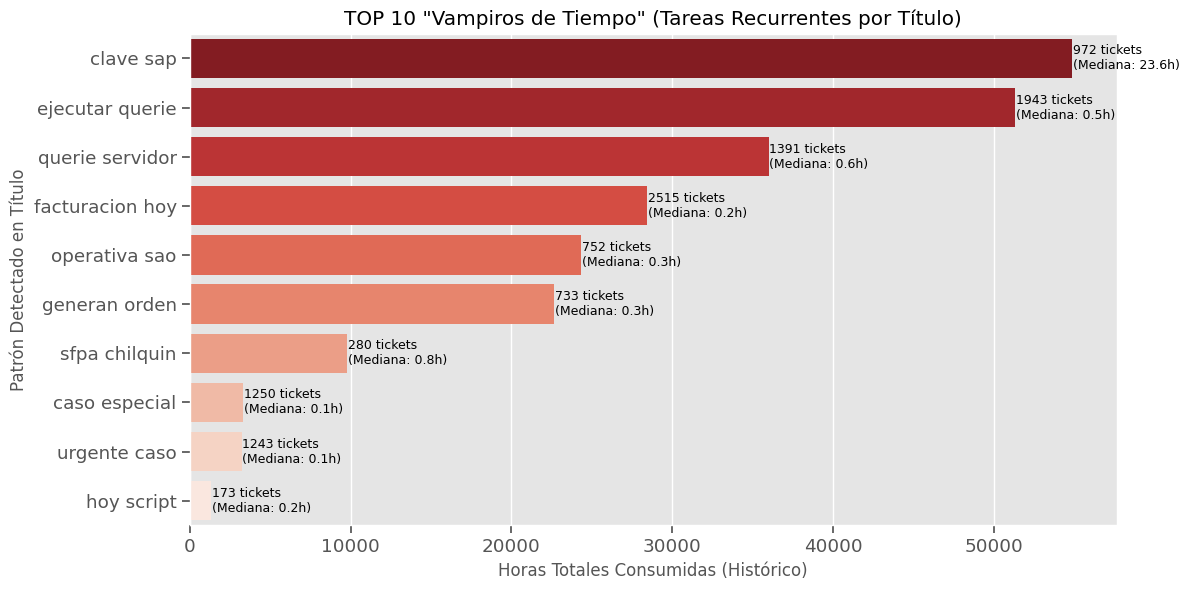

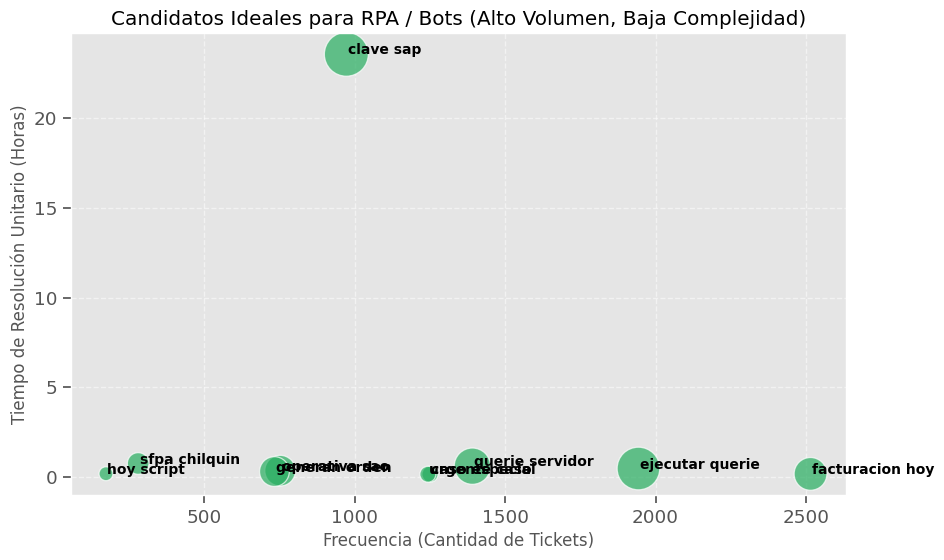

--- TABLA DE OPORTUNIDADES DE AUTOMATIZACIÓN ---
             Patron  Volumen  Tiempo_Mediana_Horas  Horas_Totales_Consumidas
15        clave sap      972                 23.56                  54897.84
8   ejecutar querie     1943                  0.47                  51344.11
10  querie servidor     1391                  0.60                  35992.14
5   facturacion hoy     2515                  0.17                  28452.01
17    operativa sao      752                  0.35                  24343.92
19    generan orden      733                  0.30                  22665.61
14    sfpa chilquin      280                  0.75                   9778.22
12    caso especial     1250                  0.15                   3325.54
11     urgente caso     1243                  0.15                   3220.35
6        hoy script      173                  0.18                   1308.23


In [6]:
#scripts para analizar los servicios de mejora segun TITULO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Configuración visual
plt.style.use('ggplot')

# --- 1. PREPARACIÓN Y LIMPIEZA DE TEXTO ---
# Filtramos solo Infraestructura (donde están los costos altos)
if 'es_infraestructura' not in df_all.columns:
    target_areas = ['DBA', 'Ingenieros TI', 'Técnico TI', 'Tecnico TI']
    df_all['es_infraestructura'] = df_all['area'].isin(target_areas)

df_infra = df_all[df_all['es_infraestructura']].copy()

# Función para limpiar títulos y extraer "conceptos"
def limpiar_y_tokenizar(textos):
    palabras_ignoradas = ['re:', 'rv:', 'fwd:', 'solicitud', 'ticket', 'de', 'el', 'la', 'en', 'y', 'a', 'para', 'con', 'por', 'incidencia', 'problema', 'error']
    
    tokens = []
    for texto in textos:
        if not isinstance(texto, str): continue
        # Limpieza básica
        txt = texto.lower()
        txt = re.sub(r'[^a-záéíóúñ ]', '', txt) # Solo letras
        words = txt.split()
        
        # Filtramos palabras vacías (stopwords)
        words = [w for w in words if w not in palabras_ignoradas and len(w) > 2]
        
        # Generamos Bigramas (Pares de palabras) -> Ej: "alta usuario", "reinicio servidor"
        # Esto da más contexto que palabras sueltas
        if len(words) >= 2:
            bigramas = [f"{words[i]} {words[i+1]}" for i in range(len(words)-1)]
            tokens.extend(bigramas)
            
    return tokens

# --- 2. MINERÍA DE TEXTO EN TÍTULOS ---
print("Analizando patrones en los títulos de los tickets...")
tokens_infra = limpiar_y_tokenizar(df_infra['titulo'])
frecuencia = Counter(tokens_infra)

# Convertimos a DataFrame para analizar
df_patrones = pd.DataFrame(frecuencia.most_common(20), columns=['Patron_Detectado', 'Frecuencia'])

# --- 3. CÁLCULO DE "ESFUERZO OCULTO" ---
# Para cada patrón, calculamos cuánto tiempo real nos ha consumido
# Esto es una aproximación: buscamos tickets que contengan ese patrón
metricas_patrones = []

for patron in df_patrones['Patron_Detectado']:
    # Buscamos tickets que contengan este bigrama en su título
    mask = df_infra['titulo'].str.lower().str.contains(patron, na=False, regex=False)
    sub_df = df_infra[mask]
    
    tiempo_total = sub_df['tiempo_vida_horas'].sum()
    tiempo_mediana = sub_df['tiempo_vida_horas'].median()
    volumen = len(sub_df)
    
    metricas_patrones.append({
        'Patron': patron,
        'Volumen': volumen,
        'Tiempo_Mediana_Horas': tiempo_mediana,
        'Horas_Totales_Consumidas': tiempo_total
    })

df_oportunidades = pd.DataFrame(metricas_patrones).sort_values('Horas_Totales_Consumidas', ascending=False)

# --- 4. VISUALIZACIÓN DE OPORTUNIDADES ---

# Gráfico 1: Top Consumidores de Tiempo (Esfuerzo Total)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_oportunidades.head(10), x='Horas_Totales_Consumidas', y='Patron', palette='Reds_r')
plt.title('TOP 10 "Vampiros de Tiempo" (Tareas Recurrentes por Título)')
plt.xlabel('Horas Totales Consumidas (Histórico)')
plt.ylabel('Patrón Detectado en Título')

# Etiquetamos con el volumen para ver si es automatizable
for i, row in enumerate(df_oportunidades.head(10).itertuples()):
    plt.text(row.Horas_Totales_Consumidas + 50, i, 
             f"{row.Volumen} tickets\n(Mediana: {row.Tiempo_Mediana_Horas:.1f}h)", 
             va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Gráfico 2: La Zona de Automatización (Alto Volumen, Tiempo Bajo/Medio)
# Filtramos para ver solo lo que tenga volumen alto
df_auto = df_oportunidades[df_oportunidades['Volumen'] > df_oportunidades['Volumen'].median()]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_auto, x='Volumen', y='Tiempo_Mediana_Horas', 
                size='Horas_Totales_Consumidas', sizes=(100, 1000), color='#27ae60', alpha=0.7, legend=False)

# Etiquetas
for _, row in df_auto.iterrows():
    plt.text(row['Volumen']+5, row['Tiempo_Mediana_Horas'], row['Patron'], weight='bold', fontsize=10)

plt.title('Candidatos Ideales para RPA / Bots (Alto Volumen, Baja Complejidad)')
plt.xlabel('Frecuencia (Cantidad de Tickets)')
plt.ylabel('Tiempo de Resolución Unitario (Horas)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("--- TABLA DE OPORTUNIDADES DE AUTOMATIZACIÓN ---")
print(df_oportunidades[['Patron', 'Volumen', 'Tiempo_Mediana_Horas', 'Horas_Totales_Consumidas']].head(10))